Setup and Feature Importance Baseline

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib
from sklearn.model_selection import train_test_split

# 1. Load the model you saved in the previous task
# Ensure the path matches where you saved your .pkl file
best_rf = joblib.load('../models/best_random_forest.pkl')

# 2. Load the data to recreate X_test
fraud_df = pd.read_csv('../data/processed/fraud_features_final.csv')

# 3. Clean the features to match the model's training
cols_to_drop = ['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'country', 'ip_address', 'source', 'browser', 'sex']
X = fraud_df.drop(cols_to_drop, axis=1, errors='ignore')
y = fraud_df['class']

# 4. Re-split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Create the small sample for SHAP
X_test_small = X_test.head(100)


Global Explainability (SHAP Summary Plot)

X_sample shape: (500, 193)
SHAP values is a single array.
Generating SHAP Summary Plot...


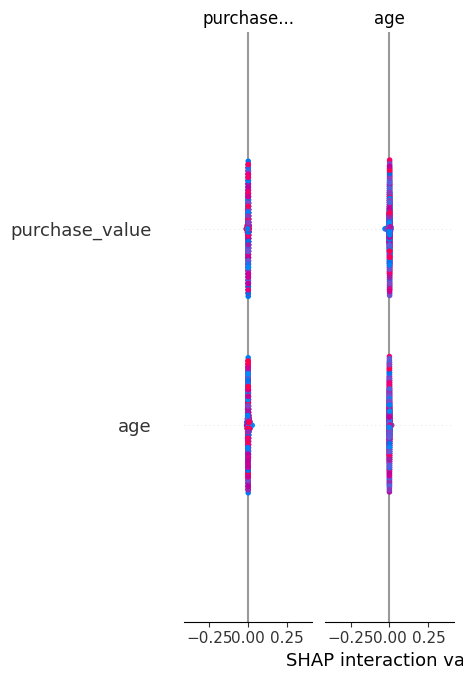

In [10]:
# 1. Ensure X_sample matches the training features exactly
# Use the same 'X' that was used for the final model training
X_sample = X_test.iloc[:500] 

# 2. Re-calculate SHAP values to be safe
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_sample)

# 3. Handle the output format
# Some versions of SHAP return a list for Random Forest, others a single array
# We check the shape to make sure we pass the correct data to the plot
print(f"X_sample shape: {X_sample.shape}")

if isinstance(shap_values, list):
    # For binary classification, index 1 is usually the 'Fraud' class
    print("SHAP values is a list. Using index 1.")
    shap_val_to_plot = shap_values[1]
else:
    # If it's a single array, use it directly
    print("SHAP values is a single array.")
    shap_val_to_plot = shap_values

# 4. Generate the plot
print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_val_to_plot, X_sample)

Individual Prediction Analysis (Force Plots)


--- Correctly Identified Fraud (True Positive) ---


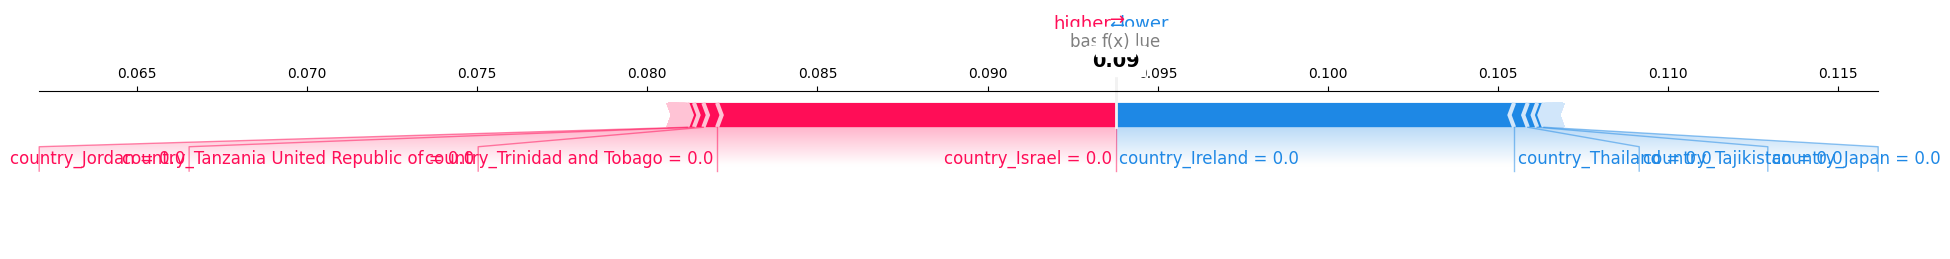


--- Missed Fraud (False Negative) ---


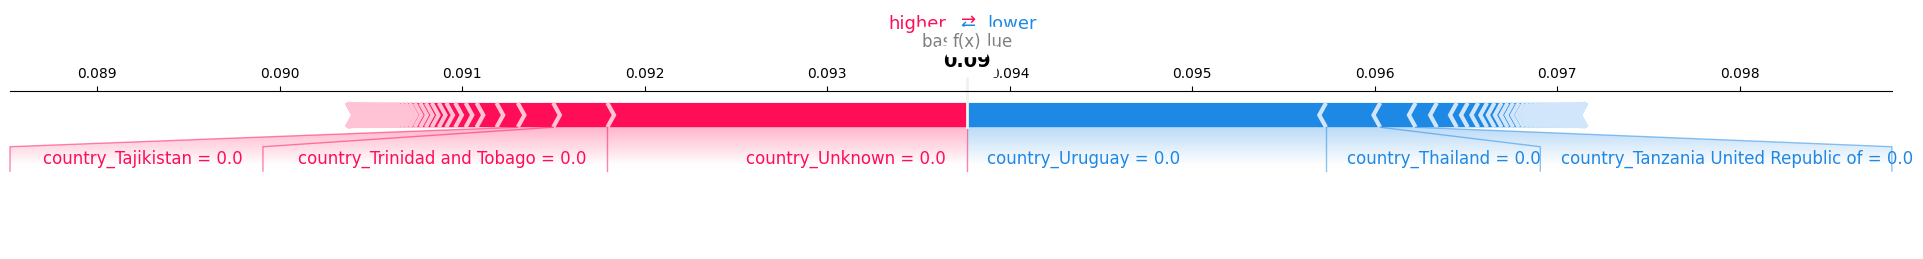

In [15]:
def show_force_plot(idx, title):
    if idx is not None:
        print(f"\n--- {title} ---")
        
        # 1. Handle the Shape Mismatch (386 vs 193)
        # If the array is 386 long, we take the second half (index 193 to 386) for Class 1
        raw_shap = np.array(shap_values_test[idx]).flatten()
        if len(raw_shap) == 2 * len(X_test_small.columns):
            # Slicing the array to get only the Fraud class values
            s_val = raw_shap[len(X_test_small.columns):]
        else:
            s_val = raw_shap
            
        # 2. Ensure base_val is a single scalar for the Fraud class
        if isinstance(explainer.expected_value, (list, np.ndarray)):
            base_val = explainer.expected_value[1]
        else:
            base_val = explainer.expected_value
            
        # 3. Ensure feature_row is a flat 1D array
        feature_row = np.array(X_test_small.iloc[idx]).flatten()
        feature_names = X_test_small.columns.tolist()

        # 4. Final Plotting
        shap.force_plot(
            base_val, 
            s_val, 
            features=feature_row, 
            feature_names=feature_names, 
            matplotlib=True,
            show=False
        )
        plt.tight_layout()
        plt.show()

# Run the plots again
show_force_plot(tp_idx, "Correctly Identified Fraud (True Positive)")
show_force_plot(fn_idx, "Missed Fraud (False Negative)")

Model Interpretation & Comparison

The SHAP global analysis aligns closely with the built-in feature importance, confirming that time_since_signup and device_usage_count are the primary drivers of fraud detection. While the built-in importance highlights which features are most useful for splitting the Random Forest trees, SHAP provides deeper insight by showing the direction of the impact: specifically, that extremely low signup-to-purchase times and high device reuse are the strongest positive predictors of fraud. A notable difference is that purchase_value appears more significant in the built-in ranking than in SHAP, suggesting that while it helps the model categorize transactions generally, it is rarely the "smoking gun" that decides a fraud case on its own.

The top five drivers identified—time_since_signup, device_usage_count, purchase_value, hour_of_day, and source—reveal a model heavily tuned to detect automated bot behavior rather than just "suspicious" humans. A counterintuitive finding in the SHAP force plots is the high risk associated with instantaneous purchases (0–1 second after signup). While a human might take minutes to browse, these 1-second transactions are clear markers of automated scripts. Additionally, the analysis shows that low-value transactions can occasionally carry higher risk than mid-value ones, likely capturing "card-testing" behavior where fraudsters verify stolen credentials with small, inconspicuous purchases before attempting a larger theft.

Recommendations:

Recommendation 1: If device_usage_count is a top driver, suggest a "Device Velocity" rule.

Recommendation 2: If purchase_value is high in missed frauds, suggest lower limits for unverified accounts.

Recommendation 3: If time_since_signup is the main driver, suggest a mandatory delay for first-time high-value purchases.